In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from case2_datagen import generate_collocation_points#, generate_interface_collocation_points
from case2_loss_fns import pde_loss, bc_loss, flexural_rigidity, normalise, denormalise
from case2_beamdoublenet import BeamDoubleNet
from case2_bayesian_opt import run_bayesian_optimisation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(16)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 16


/mnt/interns/csim/miniforge/envs/pinns/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total PDE points for the single beam: 3000


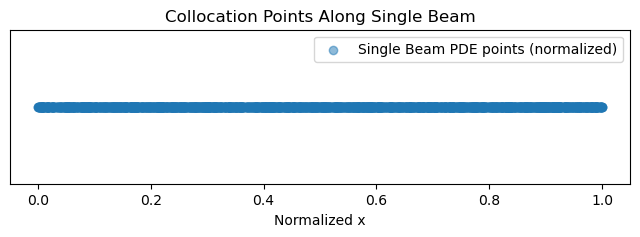

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assume the following functions are defined elsewhere:
# def generate_collocation_points(n, x_ranges): ...
# def normalise(x, xmin, xmax): ...
# def generate_interface_collocation_points(n, n_interface, x_ranges, interface_x, interface_width): ...


# --- Your Data Generation Parameters ---
n_collocation = 3000
#n_interface = 1000
#x_ranges = [(0,2), (2,3)]
#interface_x = 2.0
#interface_width = 0.1
xmin, xmax = 0.0, 3.0
qL = -500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#Generate Uniform Collocation Points for Each Domain

x_phys_pde = np.random.uniform(xmin, xmax, (n_collocation, 1)).astype(np.float32)

# --- Convert to PyTorch Tensor and Finalize ---
# Normalize the points
x_pde_torch = torch.from_numpy(normalise(x_phys_pde, xmin, xmax)).to(torch.float32).to(device)

shuffled_indices = torch.randperm(len(x_pde_torch))
x_pde_torch = x_pde_torch[shuffled_indices]
x_pde_torch.requires_grad_(True)

data = {
    'x_pde': x_pde_torch,  # Single tensor for all PDE points
    'xmin': xmin,
    'xmax': xmax,
    'device': device,
    'qL': qL,
}

print(f"Total PDE points for the single beam: {len(x_pde_torch)}")


# --- VISUALISATION (Simplified) ---
x_pde_combined_flat = x_pde_torch.cpu().detach().numpy().flatten() # Get flat array for plotting
plt.figure(figsize=(8, 2))
plt.scatter(x_pde_combined_flat, np.zeros_like(x_pde_combined_flat), alpha=0.5, label='Single Beam PDE points (normalized)')
# No interface line needed for a single beam
plt.xlabel('Normalized x')
plt.yticks([])
plt.title('Collocation Points Along Single Beam')
plt.legend()
plt.show()

In [3]:
# Bayesian search for the optimal parameters

#epochs_per_trial = 200  # A small number of epochs for the search
#n_trials = 50           # A reasonable number of trials

#print("\n--- Starting Bayesian Optimization Search ---")
#best_params = run_bayesian_optimisation(data, epochs_per_trial, n_trials, device)
#print("\n--- Search Complete. Best Parameters Found ---")
#print(best_params)

In [4]:
# Instantiate the models

n_units=40
n_layers=4
pde_weight = 10.0#best_params['pde_weight']
bc_weight = 1.0#best_params['bc_weight']
#if_weight = best_params['if_weight']
#if_cont_weight = best_params['if_cont_weight']
#if_shear_weight = best_params['if_shear_weight']
lr = 0.01#best_params['learning_rate']


model_single_beam = BeamDoubleNet(
    input_dim=1, output_dim=2,
    n_units=n_units, n_layers=n_layers,
    pde_weight=pde_weight, bc_weight=bc_weight,# if_weight=if_weight,
    #if_cont_weight=if_cont_weight, if_shear_weight=if_shear_weight,
).to(device)

#model_beam2 = BeamDoubleNet(
#    input_dim=1, output_dim=2,
#    n_units=n_units, n_layers=n_layers,
#    pde_weight=pde_weight, bc_weight=bc_weight,# if_weight=if_weight,
#    #if_cont_weight=if_cont_weight, if_shear_weight=if_shear_weight,
#).to(device)


# Set up the optimizer (a single optimizer to update the params of BOTH models)

optimizer = torch.optim.Adam(
    list(model_single_beam.parameters()),
    lr=lr
)

Epoch 0: Total Loss 1.0864e+08 | PDE 1.4542e-02 | BC 1.0864e+08
Epoch 35: Total Loss 2.2016e+04 | PDE 5.7904e-05 | BC 2.2016e+04
Epoch 70: Total Loss 5.3715e+04 | PDE 2.2758e-05 | BC 5.3715e+04
Epoch 105: Total Loss 1.4240e+02 | PDE 1.5617e-05 | BC 1.4240e+02
Epoch 140: Total Loss 1.3774e+01 | PDE 1.4930e-05 | BC 1.3774e+01
Epoch 175: Total Loss 8.5735e-01 | PDE 1.3201e-05 | BC 8.5722e-01
Epoch 210: Total Loss 2.9420e-02 | PDE 1.1565e-05 | BC 2.9304e-02
Epoch 245: Total Loss 1.0090e-03 | PDE 1.0035e-05 | BC 9.0862e-04
Epoch 280: Total Loss 2.4068e-04 | PDE 8.6690e-06 | BC 1.5399e-04
Epoch 315: Total Loss 2.2328e-04 | PDE 7.4817e-06 | BC 1.4846e-04


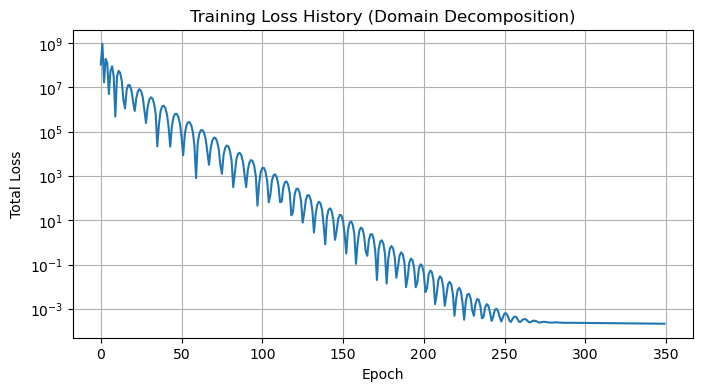

In [5]:
# training loop

losses = []
epochs=350

for ep in range(epochs):
    # This ensures x_pde_torch has requires_grad=True, even in a notebook
    #x1_pde_torch.requires_grad_(True)
    #x2_pde_torch.requires_grad_(True)          REQUIRED WHEN MINIBATCHING
    optimizer.zero_grad()

    loss_residual = pde_loss(model_single_beam, x_pde_torch, xmin, xmax, qL)# + pde_loss(model_beam2, x2_pde_torch, xmin, xmax)
    loss_boundary = bc_loss(model_single_beam, xmin, xmax, qL)
    #loss_interface = interface_loss(model_beam1, model_beam2, xmin, xmax)# if_shear_weight, if_cont_weight)

    total_loss = pde_weight*loss_residual + bc_weight*loss_boundary #+ if_weight * loss_interface

    #backpropagation and optimisation via pytorch
    total_loss.backward()
    optimizer.step()
    losses.append(total_loss.item())

    if ep % int(epochs/10) == 0:
        print(f"Epoch {ep}: Total Loss {total_loss.item():.4e} | "
              f"PDE {loss_residual.item():.4e} | "
              f"BC {loss_boundary.item():.4e}")
              #f"IF {loss_interface.item():.4e}")
        
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss History (Domain Decomposition)')
plt.grid(True)
plt.show()



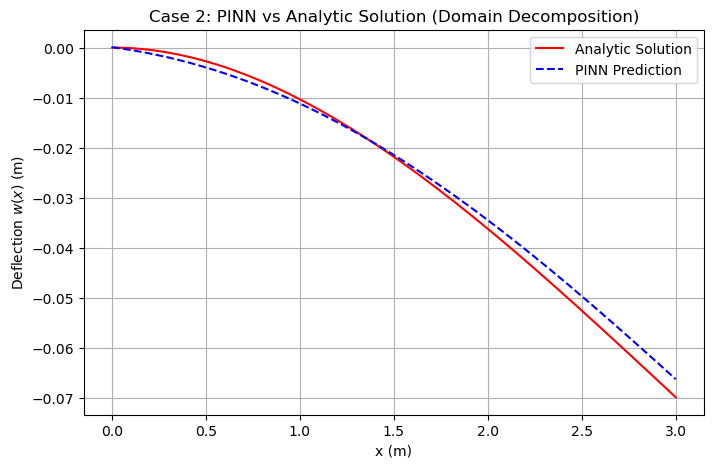

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# 1. Beam and material properties
E, D = 210e9, 0.05
I = np.pi/64 * D**4
EI = E * I

def w_analytic_point_load(x_phys, P0_val, EI_val, L_val):
    """
    Calculates the analytic deflection for a cantilever beam with an end point load.
    x_phys: physical x-coordinates (m)
    P0_val: point load (N)
    EI_val: flexural rigidity (Nm^2)
    L_val: total beam length (m)
    """
    w = (P0_val / EI_val) * (
        (L_val * x_phys**2 / 2.0) - (x_phys**3 / 6.0)
    )
    return w

# Generate x values and normalize
xmin, xmax = 0.0, 3.0
x_phys_plot = np.linspace(xmin, xmax, 500)

# Evaluate analytic solution
w_true = w_analytic_point_load(x_phys_plot, P0_val=-500, EI_val=EI, L_val=3)

x_norm_plot_torch = torch.from_numpy(normalise(x_phys_plot, xmin, xmax)).reshape(-1, 1).to(torch.float32).to(device)

# Use boolean masks to apply the correct model to each segment



w_pinn = np.zeros_like(x_phys_plot)

# Set models to evaluation mode and get predictions
model_single_beam.eval()
with torch.no_grad():
    w_pinn = model_single_beam(x_norm_plot_torch).cpu().numpy()[:, 0].flatten()


plt.figure(figsize=(8, 5))
plt.plot(x_phys_plot, w_true, 'r-', label='Analytic Solution')
plt.plot(x_phys_plot, w_pinn, 'b--', label='PINN Prediction')
plt.xlabel('x (m)')
plt.ylabel('Deflection $w(x)$ (m)')
plt.title('Case 2: PINN vs Analytic Solution (Domain Decomposition)')
plt.legend()
plt.grid(True)
plt.show()


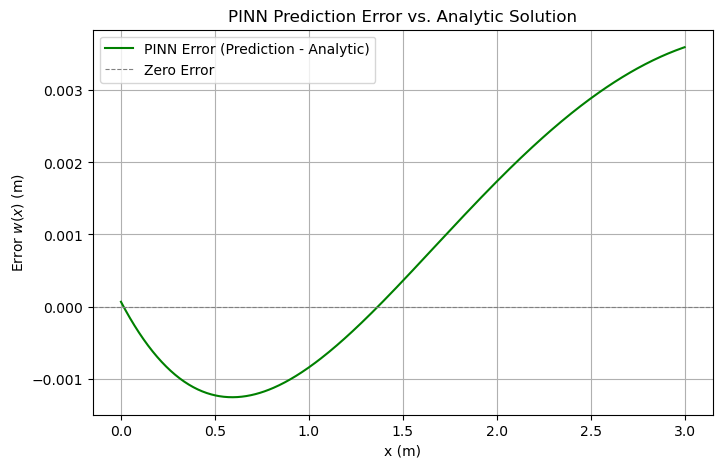

In [8]:
# error plot

error = w_pinn - w_true

# --- NEW: Plot the Error ---
plt.figure(figsize=(8, 5))
plt.plot(x_phys_plot, error, 'g-', label='PINN Error (Prediction - Analytic)')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8, label='Zero Error') # Reference line at y=0
plt.xlabel('x (m)')
plt.ylabel('Error $w(x)$ (m)')
plt.title('PINN Prediction Error vs. Analytic Solution')
plt.legend()
plt.grid(True)
plt.show()